<a href="https://colab.research.google.com/github/Mejayyy/AnomalyDet/blob/main/AD_Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch
!pip install pyod
!pip install scikit-learn
!pip install tensorflow

In [ ]:
import numpy as np

from numpy.linalg import eigh
from numpy.random import multivariate_normal
from numpy import cumsum
from pyod.utils.data import generate_data
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import roc_auc_score as ras
from scipy.io import loadmat
from pyod.utils.utility import standardizer
from numpy import quantile
from tensorflow import clip_by_value

from pyod.models.pca import PCA
from pyod.models.kpca import KPCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as ks


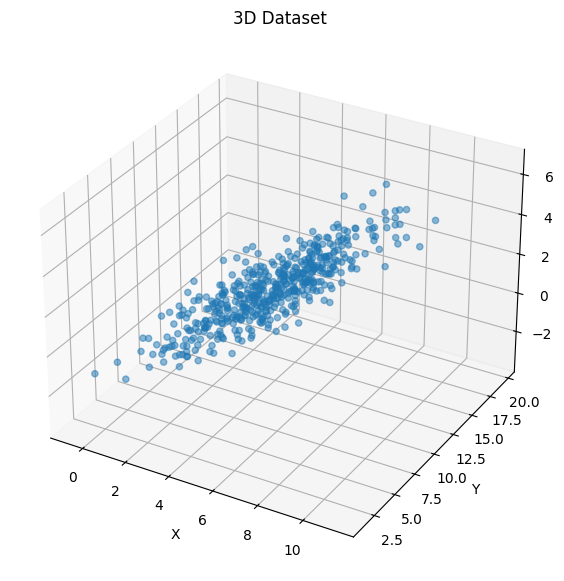

Covariance Matrix:
 [[3.42944432 2.27478248 2.40042999]
 [2.27478248 9.36161499 1.30816356]
 [2.40042999 1.30816356 2.40949161]]

Eigenvalues:
 [10.65071783  0.44266721  4.10716588]

Eigenvectors:
 [[-0.3652763  -0.6505363   0.66586466]
 [-0.89703914  0.05481611 -0.43853846]
 [-0.24878508  0.75749437  0.60357955]]


In [ ]:
#EX 1.1


mean_vector = [5, 10, 2]
covariance_matrix = [[3, 2, 2], [2, 10, 1], [2, 1, 2]]
num_points = 500

data = np.random.multivariate_normal(mean_vector, covariance_matrix, num_points)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], alpha=0.5)
ax.set_title('3D Dataset')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


data_centered = data - np.mean(data, axis=0)
cov_matrix = np.cov(data_centered, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)


print("Covariance Matrix:\n", cov_matrix)
print("\nEigenvalues:\n", eigenvalues)
print("\nEigenvectors:\n", eigenvectors)




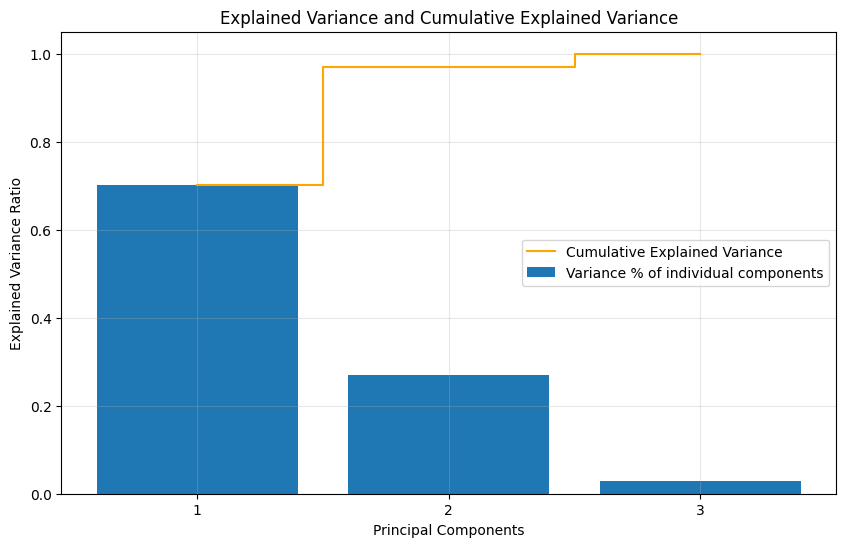

In [ ]:
#Ex 1.2
#Sorting
sorted_eigenvalues = np.sort(eigenvalues)[::-1]
cumulative_variance = np.cumsum(sorted_eigenvalues) / np.sum(sorted_eigenvalues)


plt.figure(figsize=(10, 6))
plt.bar(range(1, len(sorted_eigenvalues) + 1), sorted_eigenvalues / np.sum(sorted_eigenvalues), label="Variance % of individual components")

# Step plot
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label="Cumulative Explained Variance", color='orange')

#Legend
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance and Cumulative Explained Variance')
plt.xticks(range(1, len(sorted_eigenvalues) + 1))
plt.legend()
plt.grid(alpha=0.3)
plt.show()


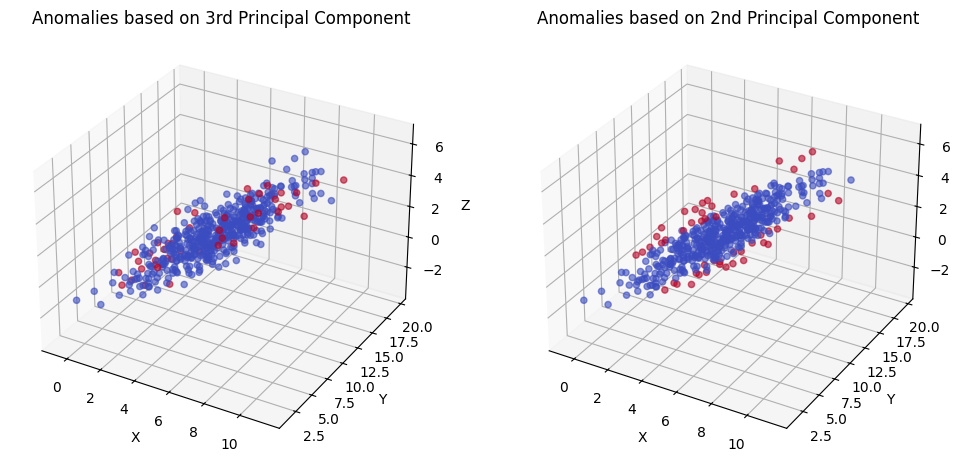

Threshold for 3rd Principal Component: 3.257964362405425
Threshold for 2nd Principal Component: 1.0888982584942017


In [ ]:
#Ex1.3
#The projection X@P
principal_components = eigenvectors
data_projected = np.dot(data_centered, principal_components)

# Outliers
cont=0.1
def detect_outliers(component_data, contamination_rate=0.1):
    threshold = np.quantile(np.abs(component_data), 1 - contamination_rate)
    labels = np.where(np.abs(component_data) > threshold, 1, 0)
    return labels, threshold

# Detect outliers based on the 3rd principal component
component_3_data = data_projected[:, 2]
labels_3, threshold_3 = detect_outliers(component_3_data, contamination_rate=0.1)

# Detect outliers based on the 2nd principal component
component_2_data = data_projected[:, 1]
labels_2, threshold_2 = detect_outliers(component_2_data, contamination_rate=0.1)

# Plotting the dataset with anomalies for the 3rd principal component
fig = plt.figure(figsize=(12, 6))

ax = fig.add_subplot(121, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=(labels_3 == 1), cmap='coolwarm', alpha=0.6)
ax.set_title('Anomalies based on 3rd Principal Component')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plotting the dataset with anomalies for the 2nd principal component
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(data[:, 0], data[:, 1], data[:, 2], c=(labels_2 == 1), cmap='coolwarm', alpha=0.6)
ax2.set_title('Anomalies based on 2nd Principal Component')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

plt.show()

# Print thresholds for both components
print(f"Threshold for 3rd Principal Component: {threshold_3}")
print(f"Threshold for 2nd Principal Component: {threshold_2}")




 STDs:  [3.26027858 0.66466674 2.02458676]

 Eigenvalues rooted:  [3.26354375 0.6653324  2.02661439]


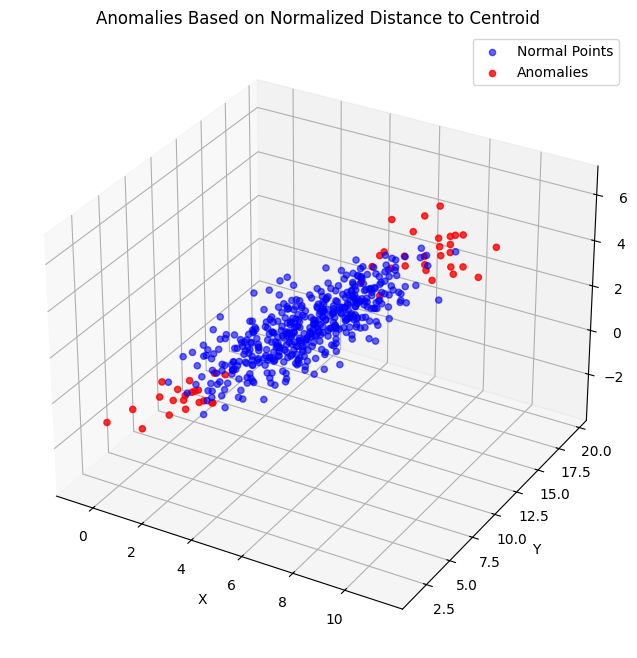

Threshold for anomaly detection: 18.431150594834936


In [ ]:
#Ex 1.4

standard_deviations = np.std(data_projected, axis=0)

print("\n STDs: ",standard_deviations )
print("\n Eigenvalues rooted: ", np.sqrt(eigenvalues))

# STD approach
#normalized_distances = np.linalg.norm(data_projected / standard_deviations, axis=1)

#Multiplying with delta**(-1/2)
normalized_distances = np.linalg.norm(np.dot(data_projected,np.diag(np.sqrt(eigenvalues))), axis=1)



contamination_rate = 0.1
threshold = np.quantile(normalized_distances, 1 - contamination_rate)


labels_all = np.where(normalized_distances > threshold, 1, 0)

#Plotting

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data[labels_all == 0, 0], data[labels_all == 0, 1], data[labels_all == 0, 2], c='blue', alpha=0.6, label='Normal Points')


ax.scatter(data[labels_all == 1, 0], data[labels_all == 1, 1], data[labels_all == 1, 2], c='red', alpha=0.8, label='Anomalies')

ax.set_title('Anomalies Based on Normalized Distance to Centroid')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()


print(f"Threshold for anomaly detection: {threshold}")


In [ ]:
#Ex 2.1

data = loadmat('shuttle.mat')

print(data.keys())

X = data['X']  # replace 'X' with the correct key if different
y = data['y']  # replace 'y' with the correct key if different

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.6)

x_train, x_test = standardizer(x_train, x_test)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

n_x_train=x_train.shape[0]
n_x_test=x_test.shape[0]

p_train,p_test=y_train[y_train==1].shape[0]/y_train.shape[0], y_test[y_test==1].shape[0]/y_test.shape[0]
cont=p_train


print("\n {:.4f} % din Train sunt anomalii. \n {:.4f} % din Test sunt anomalii. \n".format(p_train*100,p_test*100))


dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
x_train shape: (19638, 9)
x_test shape: (29459, 9)
y_train shape: (19638, 1)
y_test shape: (29459, 1)

 7.1749 % din Train sunt anomalii. 
 7.1353 % din Test sunt anomalii. 



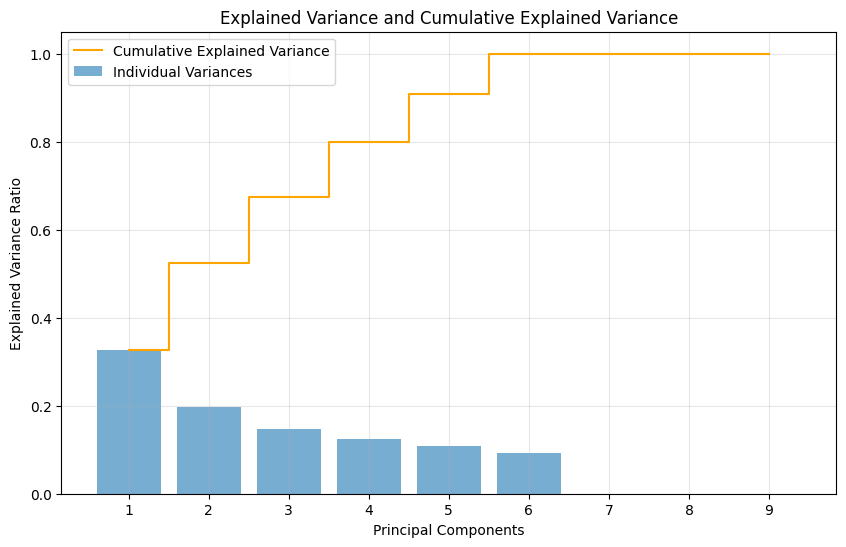

In [ ]:


# Fit PCA
model = PCA(contamination=cont, random_state=69)
model.fit(x_train)

explained_variances = model.explained_variance_ratio_
cumulative_variances = np.cumsum(explained_variances)

# Plot
plt.figure(figsize=(10, 6))


plt.bar(range(1, len(explained_variances) + 1), explained_variances, alpha=0.6, label="Individual Variances")

plt.step(range(1, len(cumulative_variances) + 1), cumulative_variances, where='mid', label="Cumulative Explained Variance", color='orange')

# Add labels and legend
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance and Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variances) + 1))
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [ ]:
#Ex 2.2 PCA
def BA(Y,Y_pred):
  cm = confusion_matrix(Y, Y_pred)

  TN, FP, FN, TP = cm.ravel()

  TPR = TP / (TP + FN)
  TNR = TN / (TN + FP)

  balanced_accuracy = (TPR + TNR) / 2
  return balanced_accuracy


y_train_pred=model.labels_

y_test_pred=model.predict(x_test)


#BA Pentru test
balanced_accuracy_train= BA(y_train,y_train_pred)
balanced_accuracy_test = BA(y_test,y_test_pred)
#auc_score = ras(y_test, y_test_scores)


print("\n BA pentru train este: ",balanced_accuracy_train)
print("\n BA pentru test este: ",balanced_accuracy_test)



 BA pentru train este:  0.9732396701673423

 BA pentru test este:  0.9739462608905118


In [ ]:
#KPCA Folosesc doar o parte din x_train si x_test pentru ca imi intrerupe sesiunea din cauza memoriei
index_train = np.random.choice(n_x_train, int(n_x_train*0.7), replace=False)
index_test = np.random.choice(n_x_test, int(n_x_test*0.7), replace=False)

x_train_sample=x_train[index_train]
x_test_sample=x_test[index_test]

"""
train_data = np.random.choice(x_train,size=int(n_x_train*0.5))
train_data = train_data.reset_index(drop=True)
test_data = np.random.choice(x_test,size=int(n_x_train*0.5))
test_data = test_data.reset_index(drop=True)
"""

model = KPCA(contamination=cont, random_state=42)
model.fit(x_train_sample)


y_train_pred=model.labels_

y_test_pred=model.predict(x_test_sample)

#BA Pentru test
balanced_accuracy_train= BA(y_train[index_train],y_train_pred)
balanced_accuracy_test = BA(y_test[index_test],y_test_pred)



print("\n BA pentru train este: ",balanced_accuracy_train)
print("\n BA pentru test este: ",balanced_accuracy_test)



 BA pentru train este:  0.616453498925378

 BA pentru test este:  0.7981389666996527


In [ ]:
#Ex 3.1

data = loadmat('shuttle.mat')

print(data.keys())

X = data['X']
y = data['y']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])
x_train shape: (24548, 9)
x_test shape: (24549, 9)
y_train shape: (24548, 1)
y_test shape: (24549, 1)


In [ ]:
#Ex 3.2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense

class autoconvo(Model):
    def __init__(self):
        super(autoconvo, self).__init__()

        self.encoder = Sequential([
            Dense(8, activation='relu'),
            Dense(5, activation='relu'),
            Dense(3, activation='relu')
        ])

        self.decoder = Sequential([
            Dense(5, activation='relu'),
            Dense(8, activation='relu'),
            Dense(9, activation='sigmoid')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


auto = autoconvo()

print("Encoder Summary:")
auto.encoder.summary()

print("\nDecoder Summary:")
auto.decoder.summary()

Encoder Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Decoder Summary:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0235 - val_loss: 0.0225
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0223 - val_loss: 0.0214
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0211 - val_loss: 0.0202
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0201 - val_loss: 0.0192
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0190 - val_loss: 0.0182
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0181 - val_loss: 0.0173
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.0164
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0163 - val_loss: 0.0156
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0149
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0148 - val_loss: 0.0142
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

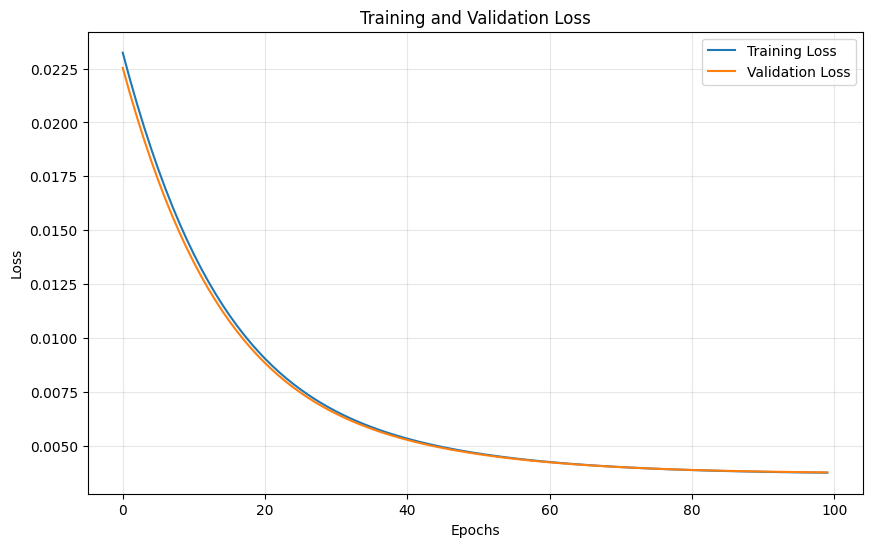

In [ ]:
#Ex 3.3

auto.compile(optimizer='adam', loss='mse')

# Train the autoconvo
stats = auto.fit(
    x_train, x_train,  # Input and target are the same for autoconvos
    epochs=100,
    batch_size=1024,
    validation_data=(x_test, x_test),
    verbose=1
)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(stats.history['loss'], label='Training Loss')
plt.plot(stats.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [ ]:
#Ex 3.4

recon = auto.predict(x_train)
recon_error_train = np.mean((x_train - recon) ** 2, axis=1)


threshold = np.quantile(recon_error_train, 1 - cont)

y_train_pred = (recon_error_train > threshold).astype(int)
ba_train = BA(y_train, y_train_pred)

# Step 4: Get recon errors for the test data
recon_test = auto.predict(x_test)
recon_error_test = np.mean((x_test - recon_test) ** 2, axis=1)

# Classify test data based on the threshold
y_test_pred = (recon_error_test > threshold).astype(int)  # 1 for anomaly, 0 for normal

# Compute balanced accuracy for the test set
ba_test = BA(y_test, y_test_pred)

# Output results
print("Threshold for classification:", threshold)
print("Balanced Accuracy (Training): {:.4f}".format(ba_train))
print("Balanced Accuracy (Testing): {:.4f}".format(ba_test))



768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
768/768 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Threshold for classification: 0.01013337922323927
Balanced Accuracy (Training): 0.9706
Balanced Accuracy (Testing): 0.9741


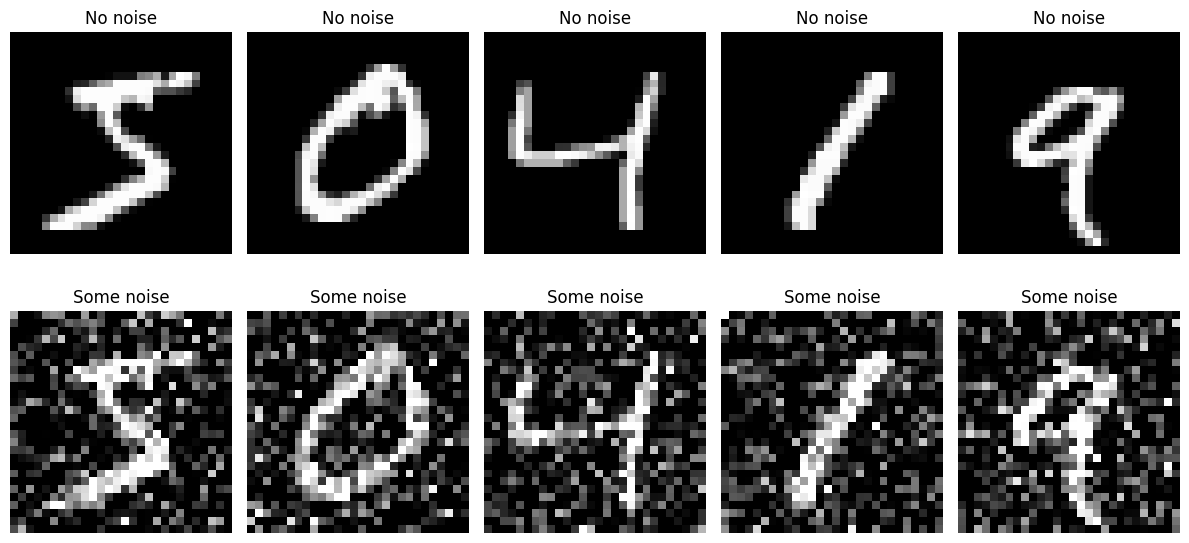

In [73]:
#Ex 4.1

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

#x_t, x_val, y_t, y_val=train_test_split(x_train,y_train, test_size=1/6)



train_noise = tf.random.normal(shape=x_train.shape, mean=0.0, stddev=1.0) * 0.35
test_noise = tf.random.normal(shape=x_test.shape, mean=0.0, stddev=1.0) * 0.35


x_train_noisy = tf.clip_by_value(x_train + train_noise, 0.0, 1.0)
x_test_noisy = tf.clip_by_value(x_test + test_noise, 0.0, 1.0)

plt.figure(figsize=(12, 6))


for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i], cmap='gray')
    plt.axis('off')
    plt.title("No noise")

for i in range(5):
    plt.subplot(2, 5, i + 6)
    plt.imshow(x_train_noisy[i], cmap='gray')
    plt.axis('off')
    plt.title("Some noise")

plt.tight_layout()
plt.show()

In [74]:
#Ex 4.2
from tensorflow.keras import layers

class AutoConvo(Model):
    def __init__(self):
        super(AutoConvo, self).__init__()

        # Encoder
        self.encoder = Sequential([
            layers.Conv2D(8, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(4, (3, 3), activation='relu', strides=2, padding='same')
        ])

        # Decoder
        self.decoder = Sequential([
            layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2DTranspose(8, (3, 3), activation='relu', strides=2, padding='same'),
            layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded




sample=np.expand_dims(x_train[0], axis=(0,3))

autoconvo = AutoConvo()
output = autoconvo(sample)

print("Input shape:", sample.shape)
print("Output shape:", output.shape)


Input shape: (1, 28, 28, 1)
Output shape: (1, 28, 28, 1)


In [75]:
#Ex 4.3
autoconvo.compile(optimizer='adam', loss='mse')
# Train
stats = autoconvo.fit(
    x_train, x_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test, x_test),
    verbose=1
)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_test_noisy = np.expand_dims(x_test_noisy, axis=-1)
x_train_noisy = np.expand_dims(x_train_noisy, axis=-1)

#Reconstructed images

recon_train = autoconvo.predict(x_train)

recon_test = autoconvo.predict(x_test)
recon_noisy_test = autoconvo.predict(x_test_noisy)

print(x_test_noisy.shape)
#Errors

threshold = np.mean(recon_error_train) + np.std(recon_error_train)

recon_error_train = np.mean((x_train - recon_train) ** 2, axis=(1, 2, 3))
recon_error_test = np.mean((x_test - recon_test) ** 2, axis=(1, 2, 3))

recon_error_noisy_test = np.mean((x_test_noisy - recon_noisy_test) ** 2, axis=(1, 2, 3))

# Labeling
y_test_pred = (recon_error_test > threshold).astype(int)
y_noisy_test_pred = (recon_error_noisy_test > threshold).astype(int)

# Accuracy uri
y_test_true = np.zeros_like(y_test_pred)
y_noisy_test_true = np.ones_like(y_noisy_test_pred)

accuracy_original = np.mean(y_test_pred == y_test_true)
accuracy_noisy = np.mean(y_noisy_test_pred == y_noisy_test_true)


print(f"Threshold for classification: {threshold}")
print(f"Accuracy on original test images: {accuracy_original:.4f}")
print(f"Accuracy on noisy test images: {accuracy_noisy:.4f}")





Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - loss: 0.0761 - val_loss: 0.0043
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 38ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 34s 36ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0023 - val_loss: 0.0022
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - loss: 0.0022 - val_loss: 0.0021
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6m

"plt.figure(figsize=(10, 6))\nplt.plot(history.history['loss'], label='Training Loss')\nplt.plot(history.history['val_loss'], label='Validation Loss')\nplt.xlabel('Epochs')\nplt.ylabel('Loss')\nplt.title('Training and Validation Loss')\nplt.legend()\nplt.grid(alpha=0.3)\nplt.show()\n\n"

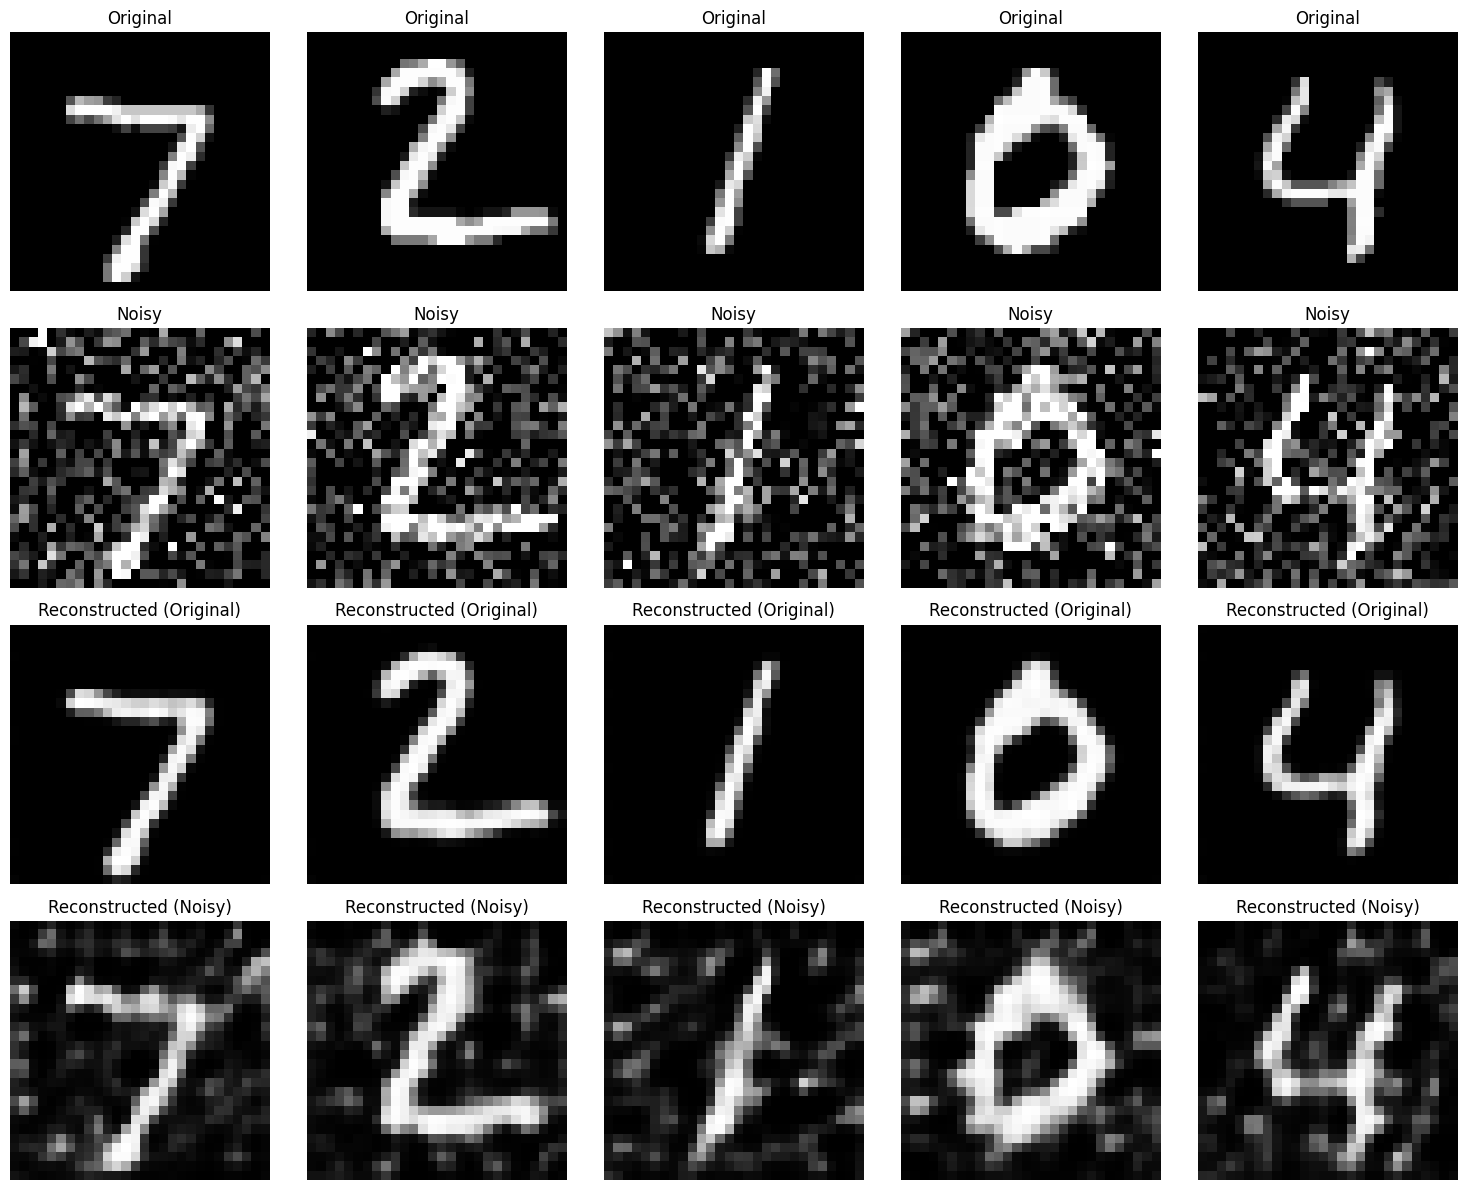

In [76]:
#Ex 4.4
plt.figure(figsize=(15, 12))

# Display original images
for i in range(5):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Original")

# Display noisy images
for i in range(5):
    plt.subplot(4, 5, i + 6)
    plt.imshow(x_test_noisy[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Noisy")

# Display reconstructed images (from original)
for i in range(5):
    plt.subplot(4, 5, i + 11)
    plt.imshow(recon_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed (Original)")

# Display reconstructed images (from noisy)
for i in range(5):
    plt.subplot(4, 5, i + 16)
    plt.imshow(recon_noisy_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed (Noisy)")

plt.tight_layout()
plt.show()


(60000, 28, 28, 1)
(60000, 28, 28, 1)
Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - loss: 0.0962 - val_loss: 0.0127
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.0118 - val_loss: 0.0101
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 35ms/step - loss: 0.0096 - val_loss: 0.0091
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - loss: 0.0091 - val_loss: 0.0088
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 46s 41ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 32s 34ms/step - loss: 0.0087 - val_loss: 0.0085
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


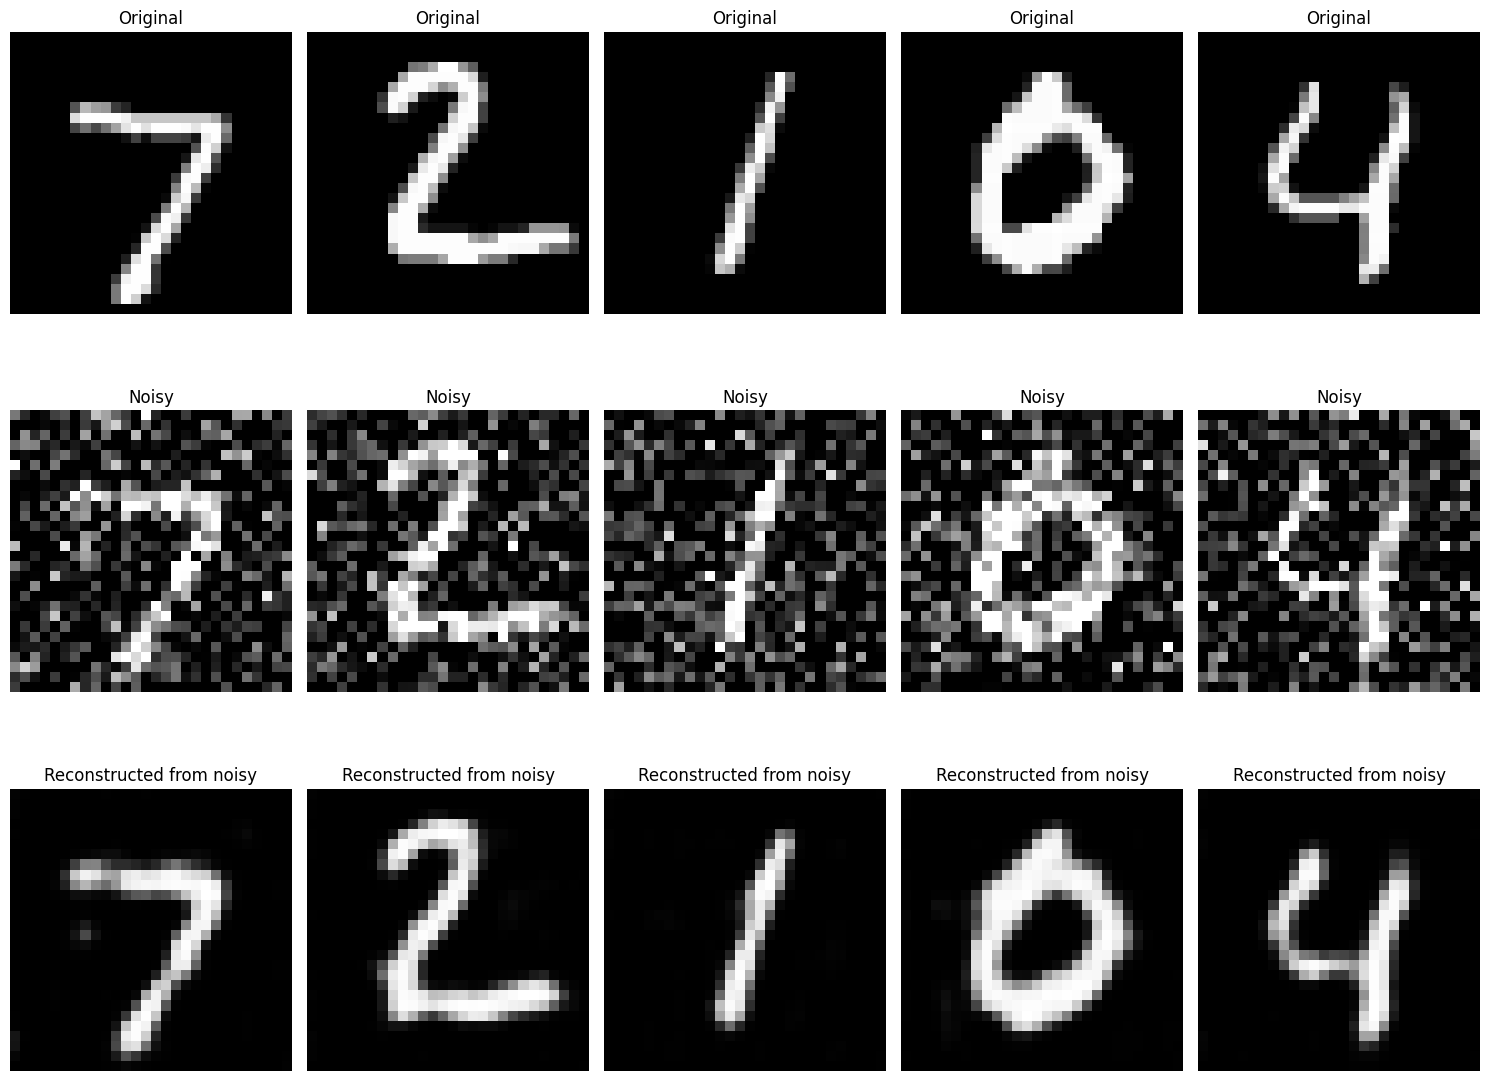

In [90]:
#Ex 4.5

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

train_noise = tf.random.normal(shape=x_train.shape, mean=0.0, stddev=1.0) * 0.35
test_noise = tf.random.normal(shape=x_test.shape, mean=0.0, stddev=1.0) * 0.35

x_train_noisy = tf.clip_by_value(x_train + train_noise, 0.0, 1.0)
x_test_noisy = tf.clip_by_value(x_test + test_noise, 0.0, 1.0)


x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train_noisy= np.expand_dims(x_train_noisy, axis=-1)
x_test_noisy= np.expand_dims(x_test_noisy, axis=-1)
print(x_train_noisy.shape)
print(x_train.shape)



denoiser = AutoConvo()
denoiser.compile(optimizer='adam', loss='mse')
# Train
history10 = denoiser.fit(
    x_train_noisy, x_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_noisy, x_test),
    verbose=1
)
"""x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_test_noisy = np.expand_dims(x_test_noisy, axis=-1)
x_train_noisy = np.expand_dims(x_train_noisy, axis=-1) """

#Reconstructed images
recon_test = denoiser.predict(x_test_noisy)


plt.figure(figsize=(15, 12))

# Display original images
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Original")

# Display noisy images
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.imshow(x_test_noisy[i], cmap='gray')
    plt.axis('off')
    plt.title("Noisy")

# Display reconstructed images (from noisy)
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.imshow(recon_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title("Reconstructed from noisy")

plt.tight_layout()
plt.show()

